# LSTM Time Series Prediction
This program uses LSTM for Time Series prognosis. The code uses Beijing Air Polution dataset which reports the level of air polution at the US embassy in Beijing, China for 5 years. The dataset can be downloaded from the UCI repository:
     https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data
        


## Python Environment
We assume you have already installed necessary components to run the code. Look at this link if you need help with the environment setup:
    http://inmachineswetrust.com/posts/deep-learning-setup/

In [1]:
from pandas import read_csv
from datetime import datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('dataset.csv')
dataset.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0


#### <span style="color:blue">As the first step of data preparation, we create a single column combining 'year', 'month', 'day', and 'hour' columns. The following code also removes the second column of the dataset('No').</span>

In [13]:
dataset = read_csv('dataset.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.head(3)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0


#### <span style="color:blue">Renaming the columns:</span>

In [14]:
dataset.columns = ['pollution', 'dew_point', 'temperature', 'pressure', 'wind_direction', 'wind_speed', 'hours_of_snow', 'hours_of_rain']
dataset.index.name = 'date'
dataset.head(1)

,pollution,dew_point,temperature,pressure,wind_direction,wind_speed,hours_of_snow,hours_of_rain
date,,,,,,,,
2010-01-01,NaN,-21,-11.0,1021.0,NW,1.79,0,0


#### <span style="color:blue">Replace NaN values with 0 and removing first 24 rows:</span>

In [15]:
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.head(3)

,pollution,dew_point,temperature,pressure,wind_direction,wind_speed,hours_of_snow,hours_of_rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0


In [20]:
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
values

array([[90.0, -7, -6.0, ..., 58.56, 4, 0],
       [63.0, -8, -6.0, ..., 61.69, 5, 0],
       [65.0, -8, -7.0, ..., 65.71, 6, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [21]:
values[0]

array([90.0, -7, -6.0, 1027.0, 'SE', 58.56, 4, 0], dtype=object)

In [23]:
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values[0]

array([  90.  ,   -7.  ,   -6.  , 1027.  ,    2.  ,   58.56,    4.  ,
          0.  ], dtype=float32)

In [29]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled[0]

array([0.09054326, 0.48529413, 0.21311474, 0.65454674, 0.6666667 ,
       0.09930788, 0.14814815, 0.        ], dtype=float32)

#### <span style="color:blue">Storing the clean dataset in a new file:</span>

In [25]:
data = scaled
n_in=1
n_out=1
dropnan=True
n_vars = 1 if type(data) is list else data.shape[1]
df = pd.DataFrame(data)
cols, names = list(), list()
n_vars  


8

In [26]:
df

,0,1,2,3,4,5,6,7
0,0.090543,0.485294,0.213115,0.654547,0.666667,0.099308,0.148148,0.0
1,0.063380,0.470588,0.213115,0.636364,0.666667,0.104657,0.185185,0.0
2,0.065392,0.470588,0.196721,0.636364,0.666667,0.111527,0.222222,0.0
3,0.055332,0.470588,0.196721,0.618183,0.666667,0.116876,0.259259,0.0
4,0.065392,0.470588,0.196721,0.600000,0.666667,0.123746,0.296296,0.0
...,...,...,...,...,...,...,...,...
43771,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43772,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43773,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43774,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [30]:
cols

[]

In [31]:
names

[]

In [32]:
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

In [50]:
cols[0:1]

[              0         1         2         3         4         5         6  \
 0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 1      0.090543  0.485294  0.213115  0.654547  0.666667  0.099308  0.148148   
 2      0.063380  0.470588  0.213115  0.636364  0.666667  0.104657  0.185185   
 3      0.065392  0.470588  0.196721  0.636364  0.666667  0.111527  0.222222   
 4      0.055332  0.470588  0.196721  0.618183  0.666667  0.116876  0.259259   
 ...         ...       ...       ...       ...       ...       ...       ...   
 43771  0.010060  0.264706  0.278689  0.763638  0.333333  0.385730  0.000000   
 43772  0.008048  0.250000  0.278689  0.781818  0.333333  0.395659  0.000000   
 43773  0.010060  0.264706  0.262295  0.781818  0.333333  0.405588  0.000000   
 43774  0.010060  0.264706  0.262295  0.781818  0.333333  0.413996  0.000000   
 43775  0.008048  0.264706  0.245902  0.781818  0.333333  0.420866  0.000000   
 
          7  
 0      NaN  
 1      0.

In [34]:
names

['var1(t-1)',
 'var2(t-1)',
 'var3(t-1)',
 'var4(t-1)',
 'var5(t-1)',
 'var6(t-1)',
 'var7(t-1)',
 'var8(t-1)']

In [36]:
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

In [37]:
cols

[              0         1         2         3         4         5         6  \
 0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 1      0.090543  0.485294  0.213115  0.654547  0.666667  0.099308  0.148148   
 2      0.063380  0.470588  0.213115  0.636364  0.666667  0.104657  0.185185   
 3      0.065392  0.470588  0.196721  0.636364  0.666667  0.111527  0.222222   
 4      0.055332  0.470588  0.196721  0.618183  0.666667  0.116876  0.259259   
 ...         ...       ...       ...       ...       ...       ...       ...   
 43771  0.010060  0.264706  0.278689  0.763638  0.333333  0.385730  0.000000   
 43772  0.008048  0.250000  0.278689  0.781818  0.333333  0.395659  0.000000   
 43773  0.010060  0.264706  0.262295  0.781818  0.333333  0.405588  0.000000   
 43774  0.010060  0.264706  0.262295  0.781818  0.333333  0.413996  0.000000   
 43775  0.008048  0.264706  0.245902  0.781818  0.333333  0.420866  0.000000   
 
          7  
 0      NaN  
 1      0.

In [51]:
names

['var1(t-1)',
 'var2(t-1)',
 'var3(t-1)',
 'var4(t-1)',
 'var5(t-1)',
 'var6(t-1)',
 'var7(t-1)',
 'var8(t-1)',
 'var1(t)',
 'var2(t)',
 'var3(t)',
 'var4(t)',
 'var5(t)',
 'var6(t)',
 'var7(t)',
 'var8(t)']

In [52]:
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
# drop rows with NaN values
if dropnan:
    agg.dropna(inplace=True)
agg

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.090543,0.485294,0.213115,0.654547,0.666667,0.099308,0.148148,0.0,0.063380,0.470588,0.213115,0.636364,0.666667,0.104657,0.185185,0.0
2,0.063380,0.470588,0.213115,0.636364,0.666667,0.104657,0.185185,0.0,0.065392,0.470588,0.196721,0.636364,0.666667,0.111527,0.222222,0.0
3,0.065392,0.470588,0.196721,0.636364,0.666667,0.111527,0.222222,0.0,0.055332,0.470588,0.196721,0.618183,0.666667,0.116876,0.259259,0.0
4,0.055332,0.470588,0.196721,0.618183,0.666667,0.116876,0.259259,0.0,0.065392,0.470588,0.196721,0.600000,0.666667,0.123746,0.296296,0.0
5,0.065392,0.470588,0.196721,0.600000,0.666667,0.123746,0.296296,0.0,0.083501,0.455882,0.180328,0.600000,0.666667,0.130616,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43772,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43773,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43774,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


#### <span style="color:blue">The following code creates a plot for each series to give us better underestanding of the dataset:</span>

<Figure size 432x288 with 0 Axes>

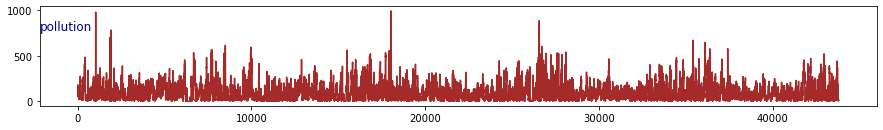

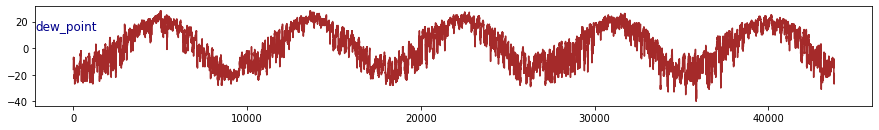

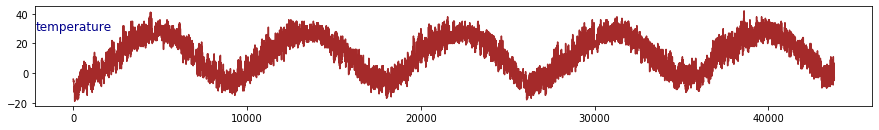

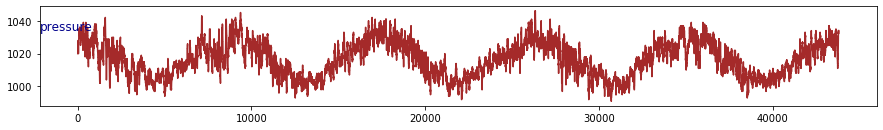

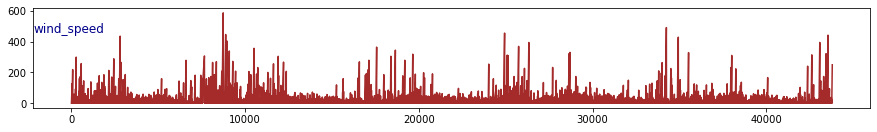

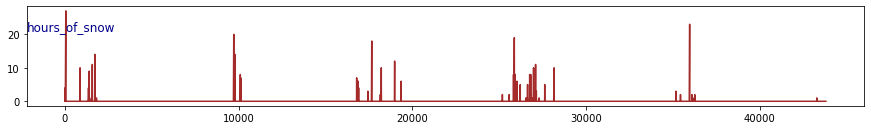

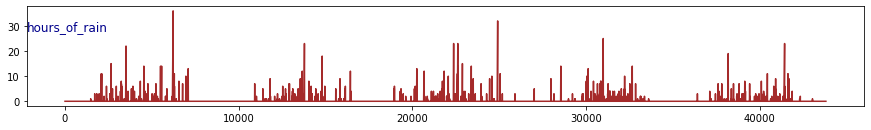

In [5]:
from matplotlib import pyplot as plt
values = dataset.values
features = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for feature in features:
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(len(features), 1, i)
    plt.plot(values[:, feature], color = 'brown')
    plt.title(dataset.columns[feature], color = 'darkblue', y=0.7, loc='left')
    i += 1

#### <span style="color:blue">The following code creates a plot for each series to give us better underestanding of the dataset:</span>

In [11]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
# convert series to supervised learning
def create_series(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = create_series(scaled, 1, 1)
# drop unnecessary 
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)


In [12]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.090543,0.485294,0.213115,0.654547,0.666667,0.099308,0.148148,0.0,0.063380
2,0.063380,0.470588,0.213115,0.636364,0.666667,0.104657,0.185185,0.0,0.065392
3,0.065392,0.470588,0.196721,0.636364,0.666667,0.111527,0.222222,0.0,0.055332
4,0.055332,0.470588,0.196721,0.618183,0.666667,0.116876,0.259259,0.0,0.065392
5,0.065392,0.470588,0.196721,0.600000,0.666667,0.123746,0.296296,0.0,0.083501
...,...,...,...,...,...,...,...,...,...
43771,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43772,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43773,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43774,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


#### <span style="color:blue">The following code splits the dataset into training and testing sets, then it reshapes the dataset into  3D format that is needed to use LSTM:</span>

<img src="files/3Dinput.jpg">

In [11]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35015, 1, 8) (35015,)


In [15]:
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
values

array([[90.0, -7, -6.0, ..., 58.56, 4, 0],
       [63.0, -8, -6.0, ..., 61.69, 5, 0],
       [65.0, -8, -7.0, ..., 65.71, 6, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [ ]:
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = create_series(scaled, 1, 1)
# drop unnecessary 
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

#### <span style="color:blue">The following code creates the LSTM model which cnsists of a LSTM layer with 100 neurons and a dense layer:</span>

C:\Users\BRG_user\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 8760 samples, validate on 35039 samples
Epoch 1/20
 - 1s - loss: 0.0528 - val_loss: 0.0476
Epoch 2/20
 - 0s - loss: 0.0335 - val_loss: 0.0474
Epoch 3/20
 - 1s - loss: 0.0207 - val_loss: 0.0432
Epoch 4/20
 - 0s - loss: 0.0175 - val_loss: 0.0346
Epoch 5/20
 - 1s - loss: 0.0159 - val_loss: 0.0227
Epoch 6/20
 - 1s - loss: 0.0150 - val_loss: 0.0182
Epoch 7/20
 - 1s - loss: 0.0148 - val_loss: 0.0177
Epoch 8/20
 - 1s - loss: 0.0149 - val_loss: 0.0164
Epoch 9/20
 - 0s - loss: 0.0149 - val_loss: 0.0158
Epoch 10/20
 - 1s - loss: 0.0147 - val_loss: 0.0151
Epoch 11/20
 - 1s - loss: 0.0146 - val_loss: 0.0149
Epoch 12/20
 - 0s - loss: 0.0147 - val_loss: 0.0146
Epoch 13/20
 - 0s - loss: 0.0145 - val_loss: 0.0142
Epoch 14/20
 - 0s - loss: 0.0145 - val_loss: 0.0139
Epoch 15/20
 - 0s - loss: 0.0145 - val_loss: 0.0140
Epoch 16/20
 - 1s - loss: 0.0145 - val_loss: 0.0140
Epoch 17/20
 - 1s - loss: 0.0145 - val_loss: 0.0137
Epoch 18/20
 - 1s - loss: 0.0145 - val_loss: 0.0138
Epoch 19/20
 - 1s - loss

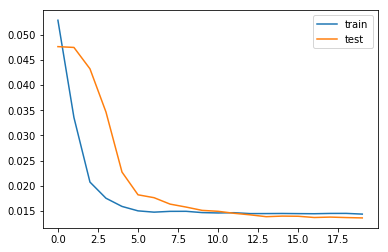

In [10]:
# design network
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### <span style="color:blue">Forecasting:</span>

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = (yhat + test_X[:, 1:])
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)